# 전처리

In [24]:
# %pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
# 경고 무시 설정
warnings.filterwarnings("ignore")


# 데이터 불러오기
file_path = 'rainfall_train.csv'
rainfall_train=pd.read_csv(file_path)

rainfall_train.head()

,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,...,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval
0,1,A,5,1,9,STN001,3,A,5,1,...,0,0,0,0,0,0,0,0,0.0,0
1,2,A,5,1,9,STN001,6,A,5,1,...,0,0,0,0,0,0,0,0,0.0,0
2,3,A,5,1,9,STN001,9,A,5,1,...,0,0,0,0,0,0,0,0,0.0,0
3,4,A,5,1,9,STN001,12,A,5,1,...,0,0,0,0,0,0,0,0,0.0,0
4,5,A,5,1,9,STN001,15,A,5,2,...,0,0,0,0,0,0,0,0,0.0,0


In [25]:
temp_df = rainfall_train
# rainfall_train.vv 열이 음수인 경우 해당 행 제거
temp_df = temp_df[temp_df['rainfall_train.vv'] >= 0]
# 'A', 'B', 'C', 'D'를 각각 2001, 2002, 2003, 2004로 변환
year_mapping = {'A': 2001, 'B': 2002, 'C': 2003, 'D': 2004}

temp_df['rainfall_train.fc_year'] = temp_df['rainfall_train.fc_year'].map(year_mapping)
temp_df['rainfall_train.ef_year'] = temp_df['rainfall_train.ef_year'].map(year_mapping)

# # 결측치 확인
# print(temp_df.isnull().sum())

# 연도, 월, 일, 시간 칼럼을 하나의 datetime 칼럼으로 결합
temp_df['rainfall_train.fc_datetime'] = pd.to_datetime(temp_df[['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
temp_df['rainfall_train.ef_datetime'] = pd.to_datetime(temp_df[['rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')

# 결합 후 원래의 연도, 월, 일, 시간 열을 제거
temp_df.drop(columns=['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour'], inplace=True)
temp_df.drop(columns=['rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'], inplace=True)
temp_df.head()

,Unnamed: 0,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval,rainfall_train.fc_datetime,rainfall_train.ef_datetime
0,1,STN001,3,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 12:00:00
1,2,STN001,6,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 15:00:00
2,3,STN001,9,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 18:00:00
3,4,STN001,12,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 21:00:00
4,5,STN001,15,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-02 00:00:00


In [26]:
# # 범주형 변수를 수치형 변수로 변환
# temp_df = pd.get_dummies(temp_df, columns=['rainfall_train.stn4contest'], drop_first=True)

# 구간 확률 계산
temp_df['prob_0'] = 100 - temp_df['rainfall_train.v01']
temp_df['prob_1'] = temp_df['rainfall_train.v01'] - temp_df['rainfall_train.v02']
temp_df['prob_2'] = temp_df['rainfall_train.v02'] - temp_df['rainfall_train.v03']
temp_df['prob_3'] = temp_df['rainfall_train.v03'] - temp_df['rainfall_train.v04']
temp_df['prob_4'] = temp_df['rainfall_train.v04'] - temp_df['rainfall_train.v05']
temp_df['prob_5'] = temp_df['rainfall_train.v05'] - temp_df['rainfall_train.v06']
temp_df['prob_6'] = temp_df['rainfall_train.v06'] - temp_df['rainfall_train.v07']
temp_df['prob_7'] = temp_df['rainfall_train.v07'] - temp_df['rainfall_train.v08']
temp_df['prob_8'] = temp_df['rainfall_train.v08'] - temp_df['rainfall_train.v09']
temp_df['prob_9'] = temp_df['rainfall_train.v09']

# datetime 정보를 유용한 특성으로 변환
temp_df['fc_year'] = temp_df['rainfall_train.fc_datetime'].dt.year
temp_df['fc_month'] = temp_df['rainfall_train.fc_datetime'].dt.month
temp_df['fc_day'] = temp_df['rainfall_train.fc_datetime'].dt.day
temp_df['fc_hour'] = temp_df['rainfall_train.fc_datetime'].dt.hour

temp_df['ef_year'] = temp_df['rainfall_train.ef_datetime'].dt.year
temp_df['ef_month'] = temp_df['rainfall_train.ef_datetime'].dt.month
temp_df['ef_day'] = temp_df['rainfall_train.ef_datetime'].dt.day
temp_df['ef_hour'] = temp_df['rainfall_train.ef_datetime'].dt.hour

# 불필요한 열 제거
temp_df.drop(columns=['rainfall_train.fc_datetime', 'rainfall_train.ef_datetime'], inplace=True)
temp_df["expected"] = (temp_df["prob_0"] * 0\
                +temp_df["prob_1"] * 10\
                +temp_df["prob_2"] * 20\
                +temp_df["prob_3"] * 30\
                +temp_df["prob_4"] * 40\
                +temp_df["prob_5"] * 50\
                +temp_df["prob_6"] * 60\
                +temp_df["prob_7"] * 70\
                +temp_df["prob_8"] * 80\
                +temp_df["prob_9"] * 90) / 100
temp_df.drop(columns=["prob_0","prob_1","prob_2","prob_3","prob_4","prob_5","prob_6","prob_7","prob_8","prob_9"], inplace=True)
temp_df

,Unnamed: 0,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,...,rainfall_train.class_interval,fc_year,fc_month,fc_day,fc_hour,ef_year,ef_month,ef_day,ef_hour,expected
0,1,STN001,3,0,0,0,0,0,0,0,...,0,2001,5,1,9,2001,5,1,12,0.0
1,2,STN001,6,0,0,0,0,0,0,0,...,0,2001,5,1,9,2001,5,1,15,0.0
2,3,STN001,9,0,0,0,0,0,0,0,...,0,2001,5,1,9,2001,5,1,18,0.0
3,4,STN001,12,0,0,0,0,0,0,0,...,0,2001,5,1,9,2001,5,1,21,0.0
4,5,STN001,15,0,0,0,0,0,0,0,...,0,2001,5,1,9,2001,5,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457247,1457248,STN020,228,9,7,2,2,0,0,0,...,3,2003,9,30,21,2003,10,10,9,2.0
1457248,1457249,STN020,231,13,9,5,3,1,0,0,...,0,2003,9,30,21,2003,10,10,12,3.1
1457249,1457250,STN020,234,13,9,5,3,1,0,0,...,4,2003,9,30,21,2003,10,10,15,3.1
1457250,1457251,STN020,237,8,6,4,2,2,0,0,...,4,2003,9,30,21,2003,10,10,18,2.2


In [31]:
# temp_df.drop(columns=['rainfall_train.stn4contest'], inplace=True) #범주형 out
# temp_df = pd.get_dummies(temp_df, columns=['rainfall_train.stn4contest'], drop_first=True)
# 특성 및 레이블 설정
X = temp_df.drop(columns=['Unnamed: 0','rainfall_train.class_interval','rainfall_train.v01','rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05','rainfall_train.v06', 'rainfall_train.v07','rainfall_train.v08', 'rainfall_train.v09','rainfall_train.vv'])
y = temp_df['rainfall_train.class_interval']
X['rainfall_train.stn4contest_STN002'].describe()

count     1448762
unique          2
top         False
freq      1376104
Name: rainfall_train.stn4contest_STN002, dtype: object

In [32]:
# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터프레임 인덱스 재설정
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# LSTM을 위한 시계열 데이터 형태로 변환
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_lstm, y_lstm = create_sequences(X_scaled, y, time_steps)

# 데이터 분할
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# # XGBoost를 위한 데이터 분할
# X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# LSTM 모델 정의
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# LSTM 모델 훈련
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1)

# 예측
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.round(y_pred_lstm).astype(int).flatten()

Epoch 1/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 166s 5ms/step - loss: 2.3335 - val_loss: 1.9371
Epoch 2/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 163s 5ms/step - loss: 1.8510 - val_loss: 1.6844
Epoch 3/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 161s 5ms/step - loss: 1.6337 - val_loss: 1.5537
Epoch 4/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 157s 5ms/step - loss: 1.5044 - val_loss: 1.4530
Epoch 5/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 160s 5ms/step - loss: 1.4139 - val_loss: 1.3990
Epoch 6/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 164s 5ms/step - loss: 1.3433 - val_loss: 1.3190
Epoch 7/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 172s 5ms/step - loss: 1.2788 - val_loss: 1.2700
Epoch 8/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 169s 5ms/step - loss: 1.2355 - val_loss: 1.2208
Epoch 9/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 167s 5ms/step - loss: 1.1879 - val_loss: 1.1890
Epoch 10/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 165s 5ms/step - loss: 1.1503 - val_loss: 1.1608
9055/9055 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.96      0.87      0.91    244830
           1       0.04      0.29      0.07      4288
           2       0.10      0.16      0.13      6782
           3       0.12      0.13      0.12      6058
           4       0.17      0.15      0.16      6567
           5       0.27      0.18      0.22      8301
           6       0.26      0.22      0.24      5527
           7       0.31      0.21      0.25      4270
           8       0.27      0.16      0.20      1682
           9       0.44      0.03      0.06      1446

    accuracy                           0.76    289751
   macro avg       0.27      0.22      0.22    289751
weighted avg       0.85      0.76      0.80    289751

[[     0      0      0      0      0      0      0      0      0      0
       0]
 [    56 212731  23316   5082   2075    918    455    164     28      5
       0]
 [     0   1924   1254 

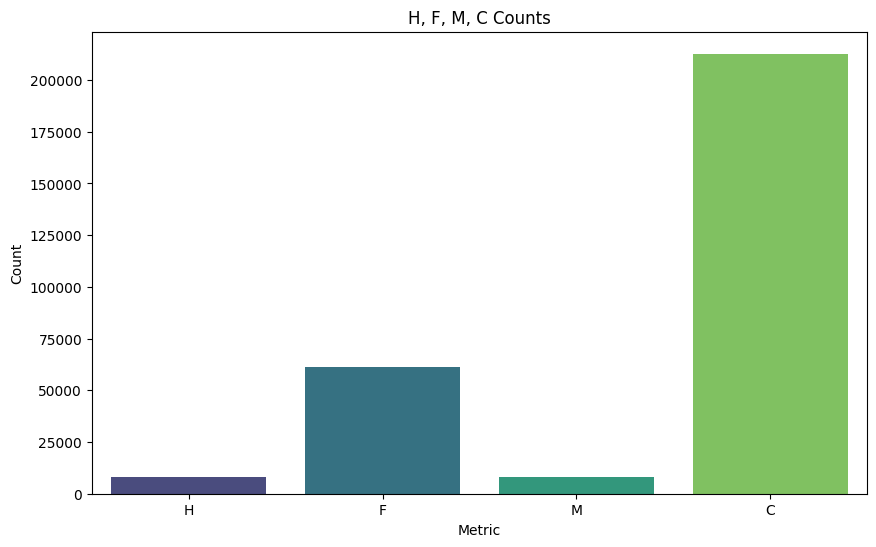

In [34]:
# 평가
print(classification_report(y_test_lstm, y_pred_lstm))
print(confusion_matrix(y_test_lstm, y_pred_lstm))

# 최종 예측 결과를 데이터프레임에 추가
results_df = pd.DataFrame({'estimated_rank': y_pred_lstm, 'rainfall_train.class_interval': y_test_lstm})

# H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['estimated_rank'] != df['rainfall_train.class_interval'])).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(results_df)

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")

# H, F, M, C 값 시각화
metrics = pd.DataFrame({'Metric': ['H', 'F', 'M', 'C'], 'Count': [H, F, M, C]})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Count', data=metrics, palette='viridis')
plt.title('H, F, M, C Counts')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.show()

In [21]:
# # 최종 예측
# final_predictions = stacking_model.predict(stacked_predictions)

# # 원본 데이터에 예측값 추가
# original_df = pd.read_csv(file_path)
# original_df['estimated_rank'] = np.nan  # 빈 열 추가
# original_df.loc[:min_len - 1, 'estimated_rank'] = final_predictions  # 예측값 추가

# 결과를 새로운 CSV 파일로 저장
results_df.to_csv('rainfall_predictions.csv', index=False)

In [91]:
# 데이터 불러오기
file_path = 'rainfall_predictions.csv'
rainfall_predictions=pd.read_csv(file_path)
rainfall_predictions['estimated_rank'].describe()

count    289751.000000
mean          0.664498
std           1.743842
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: estimated_rank, dtype: float64

In [92]:
rainfall_predictions['estimated_rank'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1457252 entries, 0 to 1457251
Series name: estimated_rank
Non-Null Count   Dtype  
--------------   -----  
289751 non-null  float64
dtypes: float64(1)
memory usage: 11.1 MB


In [103]:
rainfall_predictions['estimated_rank'].value_counts()

estimated_rank
0.0    244618
5.0      8226
2.0      6817
4.0      6777
3.0      6120
6.0      5790
7.0      5547
1.0      4205
9.0      1325
8.0       326
Name: count, dtype: int64

In [ ]:
    # %pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
# 경고 무시 설정
warnings.filterwarnings("ignore")


# 데이터 불러오기
file_path = 'rainfall_train.csv'
rainfall_train=pd.read_csv(file_path)

rainfall_train.head()


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval
0,1,A,5,1,9,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0
1,2,A,5,1,9,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0
2,3,A,5,1,9,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0
3,4,A,5,1,9,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0
4,5,A,5,1,9,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0


In [ ]:
rainfall_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457252 entries, 0 to 1457251
Data columns (total 22 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Unnamed: 0                     1457252 non-null  int64  
 1   rainfall_train.fc_year         1457252 non-null  object 
 2   rainfall_train.fc_month        1457252 non-null  int64  
 3   rainfall_train.fc_day          1457252 non-null  int64  
 4   rainfall_train.fc_hour         1457252 non-null  int64  
 5   rainfall_train.stn4contest     1457252 non-null  object 
 6   rainfall_train.dh              1457252 non-null  int64  
 7   rainfall_train.ef_year         1457252 non-null  object 
 8   rainfall_train.ef_month        1457252 non-null  int64  
 9   rainfall_train.ef_day          1457252 non-null  int64  
 10  rainfall_train.ef_hour         1457252 non-null  int64  
 11  rainfall_train.v01             1457252 non-null  int64  
 12  rainfall_train

In [ ]:
temp_df = rainfall_train
# rainfall_train.vv 열이 음수인 경우 해당 행 제거
temp_df = temp_df[temp_df['rainfall_train.vv'] >= 0]
# 'A', 'B', 'C', 'D'를 각각 2001, 2002, 2003, 2004로 변환
year_mapping = {'A': 2001, 'B': 2002, 'C': 2003, 'D': 2004}

temp_df['rainfall_train.fc_year'] = temp_df['rainfall_train.fc_year'].map(year_mapping)
temp_df['rainfall_train.ef_year'] = temp_df['rainfall_train.ef_year'].map(year_mapping)

# # 결측치 확인
# print(temp_df.isnull().sum())

# 연도, 월, 일, 시간 칼럼을 하나의 datetime 칼럼으로 결합
temp_df['rainfall_train.fc_datetime'] = pd.to_datetime(temp_df[['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
temp_df['rainfall_train.ef_datetime'] = pd.to_datetime(temp_df[['rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')

# 결합 후 원래의 연도, 월, 일, 시간 열을 제거
temp_df.drop(columns=['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour'], inplace=True)
temp_df.drop(columns=['rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'], inplace=True)
temp_df.head()

,Unnamed: 0,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval,rainfall_train.fc_datetime,rainfall_train.ef_datetime
0,1,STN001,3,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 12:00:00
1,2,STN001,6,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 15:00:00
2,3,STN001,9,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 18:00:00
3,4,STN001,12,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-01 21:00:00
4,5,STN001,15,0,0,0,0,0,0,0,0,0,0.0,0,2001-05-01 09:00:00,2001-05-02 00:00:00


In [ ]:
# 범주형 변수를 수치형 변수로 변환
temp_df = pd.get_dummies(temp_df, columns=['rainfall_train.stn4contest'], drop_first=True)

# temp_df.drop(columns=['rainfall_train.stn4contest'], inplace=True) #범주형 out
# 특성 및 레이블 설정
X = temp_df.drop(columns=['rainfall_train.class_interval', 'rainfall_train.fc_datetime', 'rainfall_train.ef_datetime'])
y = temp_df['rainfall_train.class_interval']

# 구간 확률 계산
temp_df['prob_0'] = 100 - temp_df['rainfall_train.v01']
temp_df['prob_1'] = temp_df['rainfall_train.v01'] - temp_df['rainfall_train.v02']
temp_df['prob_2'] = temp_df['rainfall_train.v02'] - temp_df['rainfall_train.v03']
temp_df['prob_3'] = temp_df['rainfall_train.v03'] - temp_df['rainfall_train.v04']
temp_df['prob_4'] = temp_df['rainfall_train.v04'] - temp_df['rainfall_train.v05']
temp_df['prob_5'] = temp_df['rainfall_train.v05'] - temp_df['rainfall_train.v06']
temp_df['prob_6'] = temp_df['rainfall_train.v06'] - temp_df['rainfall_train.v07']
temp_df['prob_7'] = temp_df['rainfall_train.v07'] - temp_df['rainfall_train.v08']
temp_df['prob_8'] = temp_df['rainfall_train.v08'] - temp_df['rainfall_train.v09']
temp_df['prob_9'] = temp_df['rainfall_train.v09']

# datetime 정보를 유용한 특성으로 변환
temp_df['fc_year'] = temp_df['rainfall_train.fc_datetime'].dt.year
temp_df['fc_month'] = temp_df['rainfall_train.fc_datetime'].dt.month
temp_df['fc_day'] = temp_df['rainfall_train.fc_datetime'].dt.day
temp_df['fc_hour'] = temp_df['rainfall_train.fc_datetime'].dt.hour

temp_df['ef_year'] = temp_df['rainfall_train.ef_datetime'].dt.year
temp_df['ef_month'] = temp_df['rainfall_train.ef_datetime'].dt.month
temp_df['ef_day'] = temp_df['rainfall_train.ef_datetime'].dt.day
temp_df['ef_hour'] = temp_df['rainfall_train.ef_datetime'].dt.hour

# 불필요한 열 제거
temp_df.drop(columns=['rainfall_train.fc_datetime', 'rainfall_train.ef_datetime'], inplace=True)

# 데이터 확인
print(temp_df.head())

# 특성 및 레이블 설정
X = temp_df.drop(columns=['rainfall_train.class_interval'])
y = temp_df['rainfall_train.class_interval']

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터프레임 인덱스 재설정
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# LSTM을 위한 시계열 데이터 형태로 변환
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_lstm, y_lstm = create_sequences(X_scaled, y, time_steps)

# 데이터 분할
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# XGBoost를 위한 데이터 분할
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

   Unnamed: 0  rainfall_train.dh  rainfall_train.v01  rainfall_train.v02  \
0           1                  3                   0                   0   
1           2                  6                   0                   0   
2           3                  9                   0                   0   
3           4                 12                   0                   0   
4           5                 15                   0                   0   

   rainfall_train.v03  rainfall_train.v04  rainfall_train.v05  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   rainfall_train.v06  rainfall_train.v07  rainfall_train.v08  \
0                   0                   0                   0   
1                   0 

In [ ]:
# LSTM 모델 정의
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# LSTM 모델 훈련
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1)

# 예측
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.round(y_pred_lstm).astype(int).flatten()

Epoch 1/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - loss: 1.7271 - val_loss: 1.4674
Epoch 2/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - loss: 1.4255 - val_loss: 1.3164
Epoch 3/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 1.2833 - val_loss: 1.2058
Epoch 4/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step - loss: 1.1577 - val_loss: 1.1114
Epoch 5/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 1.0618 - val_loss: 1.0351
Epoch 6/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - loss: 0.9913 - val_loss: 0.9896
Epoch 7/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 0.9376 - val_loss: 0.9347
Epoch 8/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step - loss: 0.8948 - val_loss: 0.9049
Epoch 9/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 0.8679 - val_loss: 0.8790
Epoch 10/10
32597/32597 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step - loss: 0.8408 - val_loss: 0.8432
9055/9055 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [ ]:
# XGBoost 모델 정의
model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)
model_xgb.fit(X_train_xgb, y_train_xgb)

# 예측
y_pred_xgb = model_xgb.predict(X_test_xgb)

In [ ]:
# 예측 결과 병합
min_len = min(len(y_pred_lstm), len(y_pred_xgb))

# 동일한 길이로 맞추기
y_pred_lstm = y_pred_lstm[:min_len]
y_pred_xgb = y_pred_xgb[:min_len]
y_test_xgb = y_test_xgb[:min_len]

stacked_predictions = np.column_stack((y_pred_lstm, y_pred_xgb))

# 스태킹 앙상블 모델 정의 (Logistic Regression 사용)
from sklearn.linear_model import LogisticRegression

stacking_model = LogisticRegression()
stacking_model.fit(stacked_predictions, y_test_xgb)

# 최종 예측
final_predictions = stacking_model.predict(stacked_predictions)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    244618
           1       1.00      1.00      1.00      4205
           2       1.00      1.00      1.00      6817
           3       1.00      0.99      1.00      6161
           4       0.99      1.00      1.00      6736
           5       1.00      1.00      1.00      8226
           6       0.96      1.00      0.98      5581
           7       0.73      0.95      0.83      4301
           8       0.64      0.12      0.21      1683
           9       1.00      0.93      0.96      1423

    accuracy                           0.99    289751
   macro avg       0.93      0.90      0.90    289751
weighted avg       0.99      0.99      0.99    289751

[[244618      0      0      0      0      0      0      0      0      0]
 [     0   4205      0      0      0      0      0      0      0      0]
 [     0      0   6817      0      0      0      0      0      0      0]
 [     0      0      0

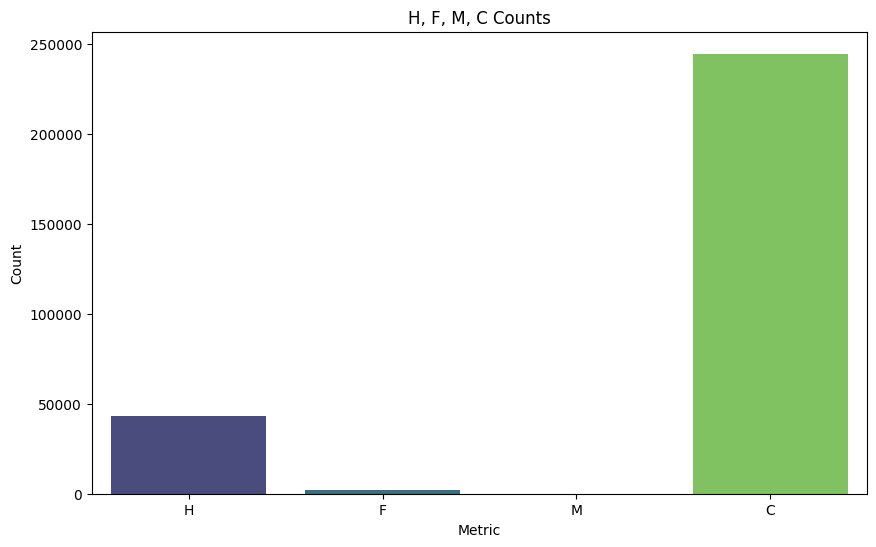

In [ ]:
# 평가
print(classification_report(y_test_xgb, final_predictions))
print(confusion_matrix(y_test_xgb, final_predictions))

# 최종 예측 결과를 데이터프레임에 추가
results_df = pd.DataFrame({'estimated_rank': final_predictions, 'rainfall_train.class_interval': y_test_xgb})

# H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['estimated_rank'] != df['rainfall_train.class_interval'])).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(results_df)

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")

# H, F, M, C 값 시각화
metrics = pd.DataFrame({'Metric': ['H', 'F', 'M', 'C'], 'Count': [H, F, M, C]})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Count', data=metrics, palette='viridis')
plt.title('H, F, M, C Counts')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.show()

In [ ]:
# 최종 예측
final_predictions = stacking_model.predict(stacked_predictions)

# 원본 데이터에 예측값 추가
original_df = pd.read_csv(file_path)
original_df['estimated_rank'] = np.nan  # 빈 열 추가
original_df.loc[:min_len - 1, 'estimated_rank'] = final_predictions  # 예측값 추가

# 결과를 새로운 CSV 파일로 저장
original_df.to_csv('rainfall_predictions.csv', index=False)

In [ ]:
# 데이터 불러오기
file_path = 'rainfall_predictions.csv'
rainfall_predictions=pd.read_csv(file_path)
rainfall_predictions['estimated_rank'].describe()

count    289751.000000
mean          0.664498
std           1.743842
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: estimated_rank, dtype: float64

In [ ]:
rainfall_predictions['estimated_rank'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1457252 entries, 0 to 1457251
Series name: estimated_rank
Non-Null Count   Dtype  
--------------   -----  
289751 non-null  float64
dtypes: float64(1)
memory usage: 11.1 MB


In [ ]:
%pip install joblib


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import joblib

In [ ]:
# 모델 저장
model_lstm.save('lstm_model.h5')

In [82]:
%pip install joblib


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [85]:
import joblib

In [86]:
# 모델 저장
model_lstm.save('lstm_model.h5')

In [87]:
# 모델 저장
joblib.dump(model_xgb, 'xgboost_model.joblib')

['xgboost_model.joblib']

In [102]:
# 스케일러 저장
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [88]:
# 모델 저장 (LSTM, XGBoost, 스태킹 모델 모두)
joblib.dump({
    'lstm_model': 'lstm_model.h5',
    'xgboost_model': 'xgboost_model.joblib',
    'stacking_model': stacking_model
}, 'stacked_model.joblib')

['stacked_model.joblib']

# 테스트 

In [101]:
# 학습 데이터에서 사용된 열을 확인하기 위해 학습 데이터를 로드
train_df = pd.read_csv('test.csv')
X_train_columns = train_df.drop(columns=['rainfall_test.class_interval']).columns

# 테스트 데이터에 대해 예측 실행
test_file_path = 'test.csv'
test_df = pd.read_csv(test_file_path)

# 'A', 'B', 'C', 'D'를 각각 2001, 2002, 2003, 2004로 변환
year_mapping = {'A': 2001, 'B': 2002, 'C': 2003, 'D': 2004}
test_df['rainfall_test.fc_year'] = test_df['rainfall_test.fc_year'].map(year_mapping)
test_df['rainfall_test.ef_year'] = test_df['rainfall_test.ef_year'].map(year_mapping)

# 연도, 월, 일, 시간 칼럼을 하나의 datetime 칼럼으로 결합
test_df['rainfall_test.fc_datetime'] = pd.to_datetime(test_df[['rainfall_test.fc_year', 'rainfall_test.fc_month', 'rainfall_test.fc_day', 'rainfall_test.fc_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
test_df['rainfall_test.ef_datetime'] = pd.to_datetime(test_df[['rainfall_test.ef_year', 'rainfall_test.ef_month', 'rainfall_test.ef_day', 'rainfall_test.ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')

# 결합 후 원래의 연도, 월, 일, 시간 열을 제거
test_df.drop(columns=['rainfall_test.fc_year', 'rainfall_test.fc_month', 'rainfall_test.fc_day', 'rainfall_test.fc_hour'], inplace=True)
test_df.drop(columns=['rainfall_test.ef_year', 'rainfall_test.ef_month', 'rainfall_test.ef_day', 'rainfall_test.ef_hour'], inplace=True)

# 구간 확률 계산
test_df['prob_0'] = 100 - test_df['rainfall_test.v01']
test_df['prob_1'] = test_df['rainfall_test.v01'] - test_df['rainfall_test.v02']
test_df['prob_2'] = test_df['rainfall_test.v02'] - test_df['rainfall_test.v03']
test_df['prob_3'] = test_df['rainfall_test.v03'] - test_df['rainfall_test.v04']
test_df['prob_4'] = test_df['rainfall_test.v04'] - test_df['rainfall_test.v05']
test_df['prob_5'] = test_df['rainfall_test.v05'] - test_df['rainfall_test.v06']
test_df['prob_6'] = test_df['rainfall_test.v06'] - test_df['rainfall_test.v07']
test_df['prob_7'] = test_df['rainfall_test.v07'] - test_df['rainfall_test.v08']
test_df['prob_8'] = test_df['rainfall_test.v08'] - test_df['rainfall_test.v09']
test_df['prob_9'] = test_df['rainfall_test.v09']

# datetime 정보를 유용한 특성으로 변환
test_df['fc_year'] = test_df['rainfall_test.fc_datetime'].dt.year
test_df['fc_month'] = test_df['rainfall_test.fc_datetime'].dt.month
test_df['fc_day'] = test_df['rainfall_test.fc_datetime'].dt.day
test_df['fc_hour'] = test_df['rainfall_test.fc_datetime'].dt.hour

test_df['ef_year'] = test_df['rainfall_test.ef_datetime'].dt.year
test_df['ef_month'] = test_df['rainfall_test.ef_datetime'].dt.month
test_df['ef_day'] = test_df['rainfall_test.ef_datetime'].dt.day
test_df['ef_hour'] = test_df['rainfall_test.ef_datetime'].dt.hour

# 불필요한 열 제거
test_df.drop(columns=['rainfall_test.fc_datetime', 'rainfall_test.ef_datetime'], inplace=True)

# 범주형 변수 변환
test_df = pd.get_dummies(test_df, columns=['rainfall_test.stn4contest'], drop_first=True)

# 학습 데이터와 테스트 데이터의 열 일치
missing_cols = set(X_train_columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[X_train_columns]

# 특성 스케일링
X_test_scaled = scaler.transform(test_df)

# LSTM 예측을 위해 시계열 데이터 형태로 변환
def create_sequences(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

time_steps = 10
X_test_lstm = create_sequences(X_test_scaled, time_steps)

# LSTM 예측
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.round(y_pred_lstm).astype(int).flatten()

# XGBoost 예측
y_pred_xgb = model_xgb.predict(test_df)

# 예측 결과 병합
min_len_test = min(len(y_pred_lstm), len(y_pred_xgb))

# 동일한 길이로 맞추기
y_pred_lstm = y_pred_lstm[:min_len_test]
y_pred_xgb = y_pred_xgb[:min_len_test]

stacked_predictions_test = np.column_stack((y_pred_lstm, y_pred_xgb))

# 스태킹 모델 예측
final_predictions_test = stacking_model.predict(stacked_predictions_test)

# 테스트 데이터에 예측값 추가
test_df['estimated_rank'] = np.nan  # 빈 열 추가
test_df.loc[:min_len_test - 1, 'estimated_rank'] = final_predictions_test  # 예측값 추가

# 결과를 새로운 CSV 파일로 저장
test_df.to_csv('test_predictions.csv', index=False)

print("Test predictions saved to 'test_predictions.csv'")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- rainfall_test.dh
- rainfall_test.ef_day
- rainfall_test.ef_hour
- rainfall_test.ef_month
- rainfall_test.ef_year
- ...
Feature names seen at fit time, yet now missing:
- Unnamed: 0
- ef_day
- ef_hour
- ef_month
- ef_year
- ...


# 전처리

In [ ]:
# %pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
# 경고 무시 설정
warnings.filterwarnings("ignore")


# 데이터 불러오기
file_path = 'rainfall_train.csv'
rainfall_train=pd.read_csv(file_path)

rainfall_train.head()


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval
0,1,A,5,1,9,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0
1,2,A,5,1,9,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0
2,3,A,5,1,9,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0
3,4,A,5,1,9,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0
4,5,A,5,1,9,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0


# 전처리

# 전처리

# 전처리

In [ ]:
# %pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
# 경고 무시 설정
warnings.filterwarnings("ignore")


# 데이터 불러오기
file_path = 'rainfall_train.csv'
rainfall_train=pd.read_csv(file_path)

rainfall_train.head()


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval
0,1,A,5,1,9,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0
1,2,A,5,1,9,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0
2,3,A,5,1,9,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0
3,4,A,5,1,9,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0
4,5,A,5,1,9,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0


In [ ]:
rainfall_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457252 entries, 0 to 1457251
Data columns (total 22 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Unnamed: 0                     1457252 non-null  int64  
 1   rainfall_train.fc_year         1457252 non-null  object 
 2   rainfall_train.fc_month        1457252 non-null  int64  
 3   rainfall_train.fc_day          1457252 non-null  int64  
 4   rainfall_train.fc_hour         1457252 non-null  int64  
 5   rainfall_train.stn4contest     1457252 non-null  object 
 6   rainfall_train.dh              1457252 non-null  int64  
 7   rainfall_train.ef_year         1457252 non-null  object 
 8   rainfall_train.ef_month        1457252 non-null  int64  
 9   rainfall_train.ef_day          1457252 non-null  int64  
 10  rainfall_train.ef_hour         1457252 non-null  int64  
 11  rainfall_train.v01             1457252 non-null  int64  
 12  rainfall_train

In [ ]:
# %pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
# 경고 무시 설정
warnings.filterwarnings("ignore")


# 데이터 불러오기
file_path = 'rainfall_train.csv'
rainfall_train=pd.read_csv(file_path)

rainfall_train.head()


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval
0,1,A,5,1,9,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0
1,2,A,5,1,9,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0
2,3,A,5,1,9,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0
3,4,A,5,1,9,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0
4,5,A,5,1,9,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0


In [ ]:
rainfall_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457252 entries, 0 to 1457251
Data columns (total 22 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Unnamed: 0                     1457252 non-null  int64  
 1   rainfall_train.fc_year         1457252 non-null  object 
 2   rainfall_train.fc_month        1457252 non-null  int64  
 3   rainfall_train.fc_day          1457252 non-null  int64  
 4   rainfall_train.fc_hour         1457252 non-null  int64  
 5   rainfall_train.stn4contest     1457252 non-null  object 
 6   rainfall_train.dh              1457252 non-null  int64  
 7   rainfall_train.ef_year         1457252 non-null  object 
 8   rainfall_train.ef_month        1457252 non-null  int64  
 9   rainfall_train.ef_day          1457252 non-null  int64  
 10  rainfall_train.ef_hour         1457252 non-null  int64  
 11  rainfall_train.v01             1457252 non-null  int64  
 12  rainfall_train

In [ ]:
# %pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
# 경고 무시 설정
warnings.filterwarnings("ignore")


# 데이터 불러오기
file_path = 'rainfall_train.csv'
rainfall_train=pd.read_csv(file_path)

rainfall_train.head()


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval
0,1,A,5,1,9,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0
1,2,A,5,1,9,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0
2,3,A,5,1,9,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0
3,4,A,5,1,9,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0
4,5,A,5,1,9,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0


In [ ]:
rainfall_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457252 entries, 0 to 1457251
Data columns (total 22 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Unnamed: 0                     1457252 non-null  int64  
 1   rainfall_train.fc_year         1457252 non-null  object 
 2   rainfall_train.fc_month        1457252 non-null  int64  
 3   rainfall_train.fc_day          1457252 non-null  int64  
 4   rainfall_train.fc_hour         1457252 non-null  int64  
 5   rainfall_train.stn4contest     1457252 non-null  object 
 6   rainfall_train.dh              1457252 non-null  int64  
 7   rainfall_train.ef_year         1457252 non-null  object 
 8   rainfall_train.ef_month        1457252 non-null  int64  
 9   rainfall_train.ef_day          1457252 non-null  int64  
 10  rainfall_train.ef_hour         1457252 non-null  int64  
 11  rainfall_train.v01             1457252 non-null  int64  
 12  rainfall_train

In [ ]:
rainfall_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457252 entries, 0 to 1457251
Data columns (total 22 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Unnamed: 0                     1457252 non-null  int64  
 1   rainfall_train.fc_year         1457252 non-null  object 
 2   rainfall_train.fc_month        1457252 non-null  int64  
 3   rainfall_train.fc_day          1457252 non-null  int64  
 4   rainfall_train.fc_hour         1457252 non-null  int64  
 5   rainfall_train.stn4contest     1457252 non-null  object 
 6   rainfall_train.dh              1457252 non-null  int64  
 7   rainfall_train.ef_year         1457252 non-null  object 
 8   rainfall_train.ef_month        1457252 non-null  int64  
 9   rainfall_train.ef_day          1457252 non-null  int64  
 10  rainfall_train.ef_hour         1457252 non-null  int64  
 11  rainfall_train.v01             1457252 non-null  int64  
 12  rainfall_train

In [83]:
# 모델 저장
model_lstm.save('lstm_model.h5')

In [84]:
# 모델 저장
joblib.dump(model_xgb, 'xgboost_model.joblib')

NameError: name 'joblib' is not defined

## 가설

총 20개의 지점에서 하루에 두 번씩(9시 21시) 예측 (3시간 뒤부터 240시간 뒤까지 3시간 간격)

하나의 지점은 한번 예측할때 총 80개 시점을 예측 (3시간 후부터 240시간 즉 10일 후까지)

예측 시점이 아니라 예측 대상 시점으로 묶을 수 있을 것(정렬).

예: 특정 날짜에 특정 지점 날씨에 대해서 이전에 예측한 최대 240시간 전부터 가장 최근에 예측을 한 예측값들이 있을 것.

각 지점은 하루에 두 번씩 예측하고 최대 10일 후 까지 예측하기 때문에, 최대 하나의 날짜, 시간에 대해 20개의 예측값이 존재할 것

또한 처음에는 5월 1일의 경우에는 예측을 5월 1일 부터 시작하였기 때문에, 각 시간별로 3시간, 6시간 전 등 예측 값 하나씩만 존재하겠지만
이후 5월 1일 이후 어느정도 시간이 지난 후(10일 이상)의 날짜를 예측하는 때에는, 하루에도 두번씩(9시, 21시) 예측하고 이전에 다른 날짜에 예측한 값이 누적되기 때문에 각 예측 대상 날짜별로 매우 많은 예측 값이 존재할 것. 아마도 10*2 = 20개

실제로 5월 11일 날짜에 대한 예측값은 20개의 예측값 존재.

이것을 어떻게 짬뽕해서 예측하냐가 모델 성능 높이는데 핵심.

## 예측 대상 시점으로 정렬 (예측 시점이 아니라)

In [67]:
rainfall_data=rainfall_train

# 데이터 프레임 정렬
sorted_rainfall_data = rainfall_data.sort_values(by=[
    'rainfall_train.stn4contest',
    'rainfall_train.ef_year', 
    'rainfall_train.ef_month', 
    'rainfall_train.ef_day', 
    'rainfall_train.ef_hour'
])

# 모든 열이 표시되도록 설정
pd.set_option('display.max_columns', None)

# 인덱스를 0부터 다시 설정하고 기존 인덱스는 버림
sorted_rainfall_data.reset_index(drop=True, inplace=True)

# 정렬된 데이터 프레임 출력
sorted_rainfall_data.loc[760:779]

#sorted_rainfall_data.to_csv('sortedver2.csv')


,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval
760,77,A,5,1,9,STN001,231,A,5,11,0,14,13,8,3,1,0,0,0,0,0.0,0
761,153,A,5,1,21,STN001,219,A,5,11,0,22,19,13,6,1,0,0,0,0,0.0,0
762,229,A,5,2,9,STN001,207,A,5,11,0,14,9,4,3,1,0,0,0,0,0.0,0
763,305,A,5,2,21,STN001,195,A,5,11,0,27,22,15,13,10,2,0,0,0,0.0,0
764,381,A,5,3,9,STN001,183,A,5,11,0,18,18,12,5,0,0,0,0,0,0.0,0
765,457,A,5,3,21,STN001,171,A,5,11,0,8,5,4,4,0,0,0,0,0,0.0,0
766,533,A,5,4,9,STN001,159,A,5,11,0,12,11,3,2,0,0,0,0,0,0.0,0
767,609,A,5,4,21,STN001,147,A,5,11,0,9,8,4,0,0,0,0,0,0,0.0,0
768,685,A,5,5,9,STN001,135,A,5,11,0,5,4,0,0,0,0,0,0,0,0.0,0
769,761,A,5,5,21,STN001,123,A,5,11,0,2,1,0,0,0,0,0,0,0,0.0,0


## A년 5월 11일 0시 STN001 강수에 대한 총 20개의 예측값

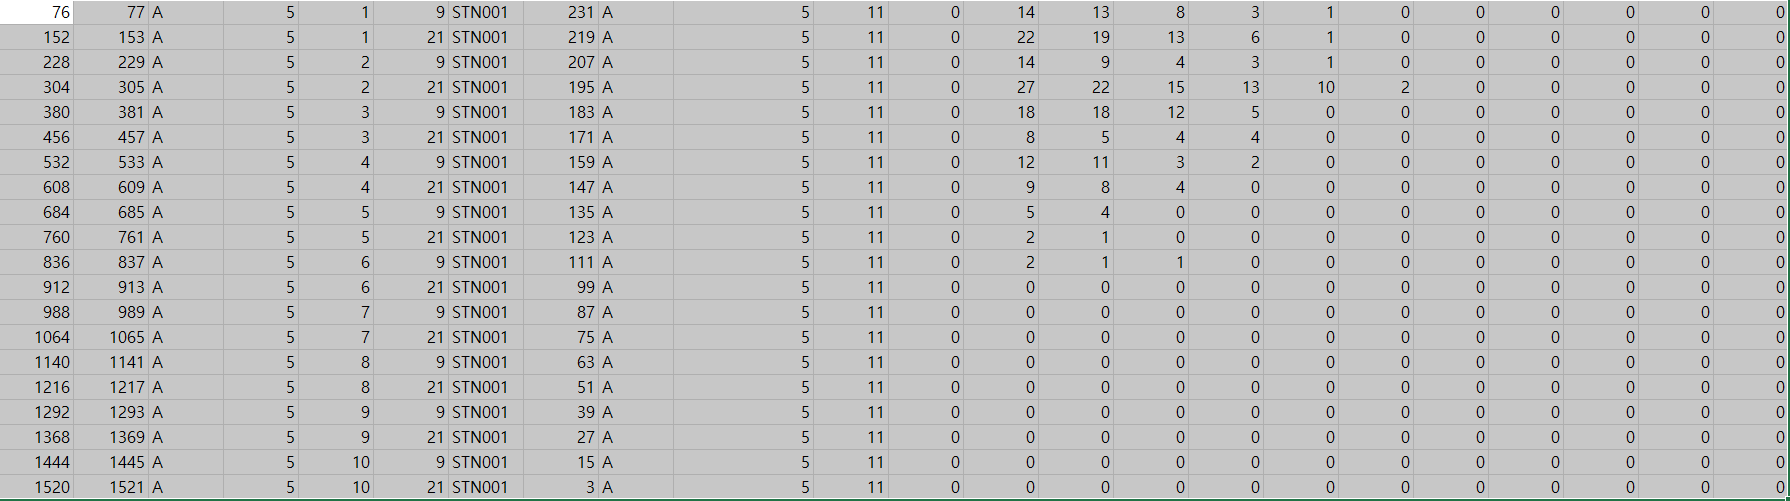

## 현재 확률 값은 상위 구간 확률 누적값이므로, 구간 확률값 계산

In [68]:
# 각 강수량 구간의 확률 계산(누적x)
seperate_df=sorted_rainfall_data

seperate_df['prob_0'] = 100 - seperate_df['rainfall_train.v01']
seperate_df['prob_1'] = seperate_df['rainfall_train.v01']- seperate_df['rainfall_train.v02']
seperate_df['prob_2'] = seperate_df['rainfall_train.v02'] - seperate_df['rainfall_train.v03']
seperate_df['prob_3'] = seperate_df['rainfall_train.v03'] - seperate_df['rainfall_train.v04']
seperate_df['prob_4'] = seperate_df['rainfall_train.v04'] - seperate_df['rainfall_train.v05']
seperate_df['prob_5'] = seperate_df['rainfall_train.v05'] - seperate_df['rainfall_train.v06']
seperate_df['prob_6'] = seperate_df['rainfall_train.v06'] - seperate_df['rainfall_train.v07']
seperate_df['prob_7'] = seperate_df['rainfall_train.v07'] - seperate_df['rainfall_train.v08']
seperate_df['prob_8'] = seperate_df['rainfall_train.v08'] - seperate_df['rainfall_train.v09']
seperate_df['prob_9'] = seperate_df['rainfall_train.v09']

seperate_df.head(20)


,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9
0,1,A,5,1,9,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0
1,2,A,5,1,9,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0
2,3,A,5,1,9,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0
3,4,A,5,1,9,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0
4,5,A,5,1,9,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0
5,81,A,5,1,21,STN001,3,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0
6,6,A,5,1,9,STN001,18,A,5,2,3,5,0,0,0,0,0,0,0,0,0.0,0,95,5,0,0,0,0,0,0,0,0
7,82,A,5,1,21,STN001,6,A,5,2,3,2,0,0,0,0,0,0,0,0,0.0,0,98,2,0,0,0,0,0,0,0,0
8,7,A,5,1,9,STN001,21,A,5,2,6,42,5,0,0,0,0,0,0,0,0.0,0,58,37,5,0,0,0,0,0,0,0
9,83,A,5,1,21,STN001,9,A,5,2,6,3,0,0,0,0,0,0,0,0,0.0,0,97,3,0,0,0,0,0,0,0,0


## prob 칼럼에서 가장 높은 확률 값을 예측 구간 설정

In [69]:
import numpy as np

# numpy 배열로 변환
prob_columns = [f'prob_{i}' for i in range(10)]
prob_array = seperate_df[prob_columns].to_numpy()

# 각 행에서 최대 값을 가진 칼럼 인덱스를 찾기
max_indices = np.argmax(prob_array, axis=1)

# 'estimated_rank' 칼럼에 할당
seperate_df['estimated_rank'] = max_indices

In [70]:
seperate_df.head()

,Unnamed: 0,rainfall_train.fc_year,rainfall_train.fc_month,rainfall_train.fc_day,rainfall_train.fc_hour,rainfall_train.stn4contest,rainfall_train.dh,rainfall_train.ef_year,rainfall_train.ef_month,rainfall_train.ef_day,rainfall_train.ef_hour,rainfall_train.v01,rainfall_train.v02,rainfall_train.v03,rainfall_train.v04,rainfall_train.v05,rainfall_train.v06,rainfall_train.v07,rainfall_train.v08,rainfall_train.v09,rainfall_train.vv,rainfall_train.class_interval,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,estimated_rank
0,1,A,5,1,9,STN001,3,A,5,1,12,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0,0
1,2,A,5,1,9,STN001,6,A,5,1,15,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0,0
2,3,A,5,1,9,STN001,9,A,5,1,18,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0,0
3,4,A,5,1,9,STN001,12,A,5,1,21,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0,0
4,5,A,5,1,9,STN001,15,A,5,2,0,0,0,0,0,0,0,0,0,0,0.0,0,100,0,0,0,0,0,0,0,0,0,0


## 결측치 제거

In [71]:
# rainfall_train.vv 열이 음수인 경우 해당 행 제거
seperate_df = seperate_df[seperate_df['rainfall_train.vv'] >= 0]

# 분석

## 각 지역(지점)별 월별 평균 강수량

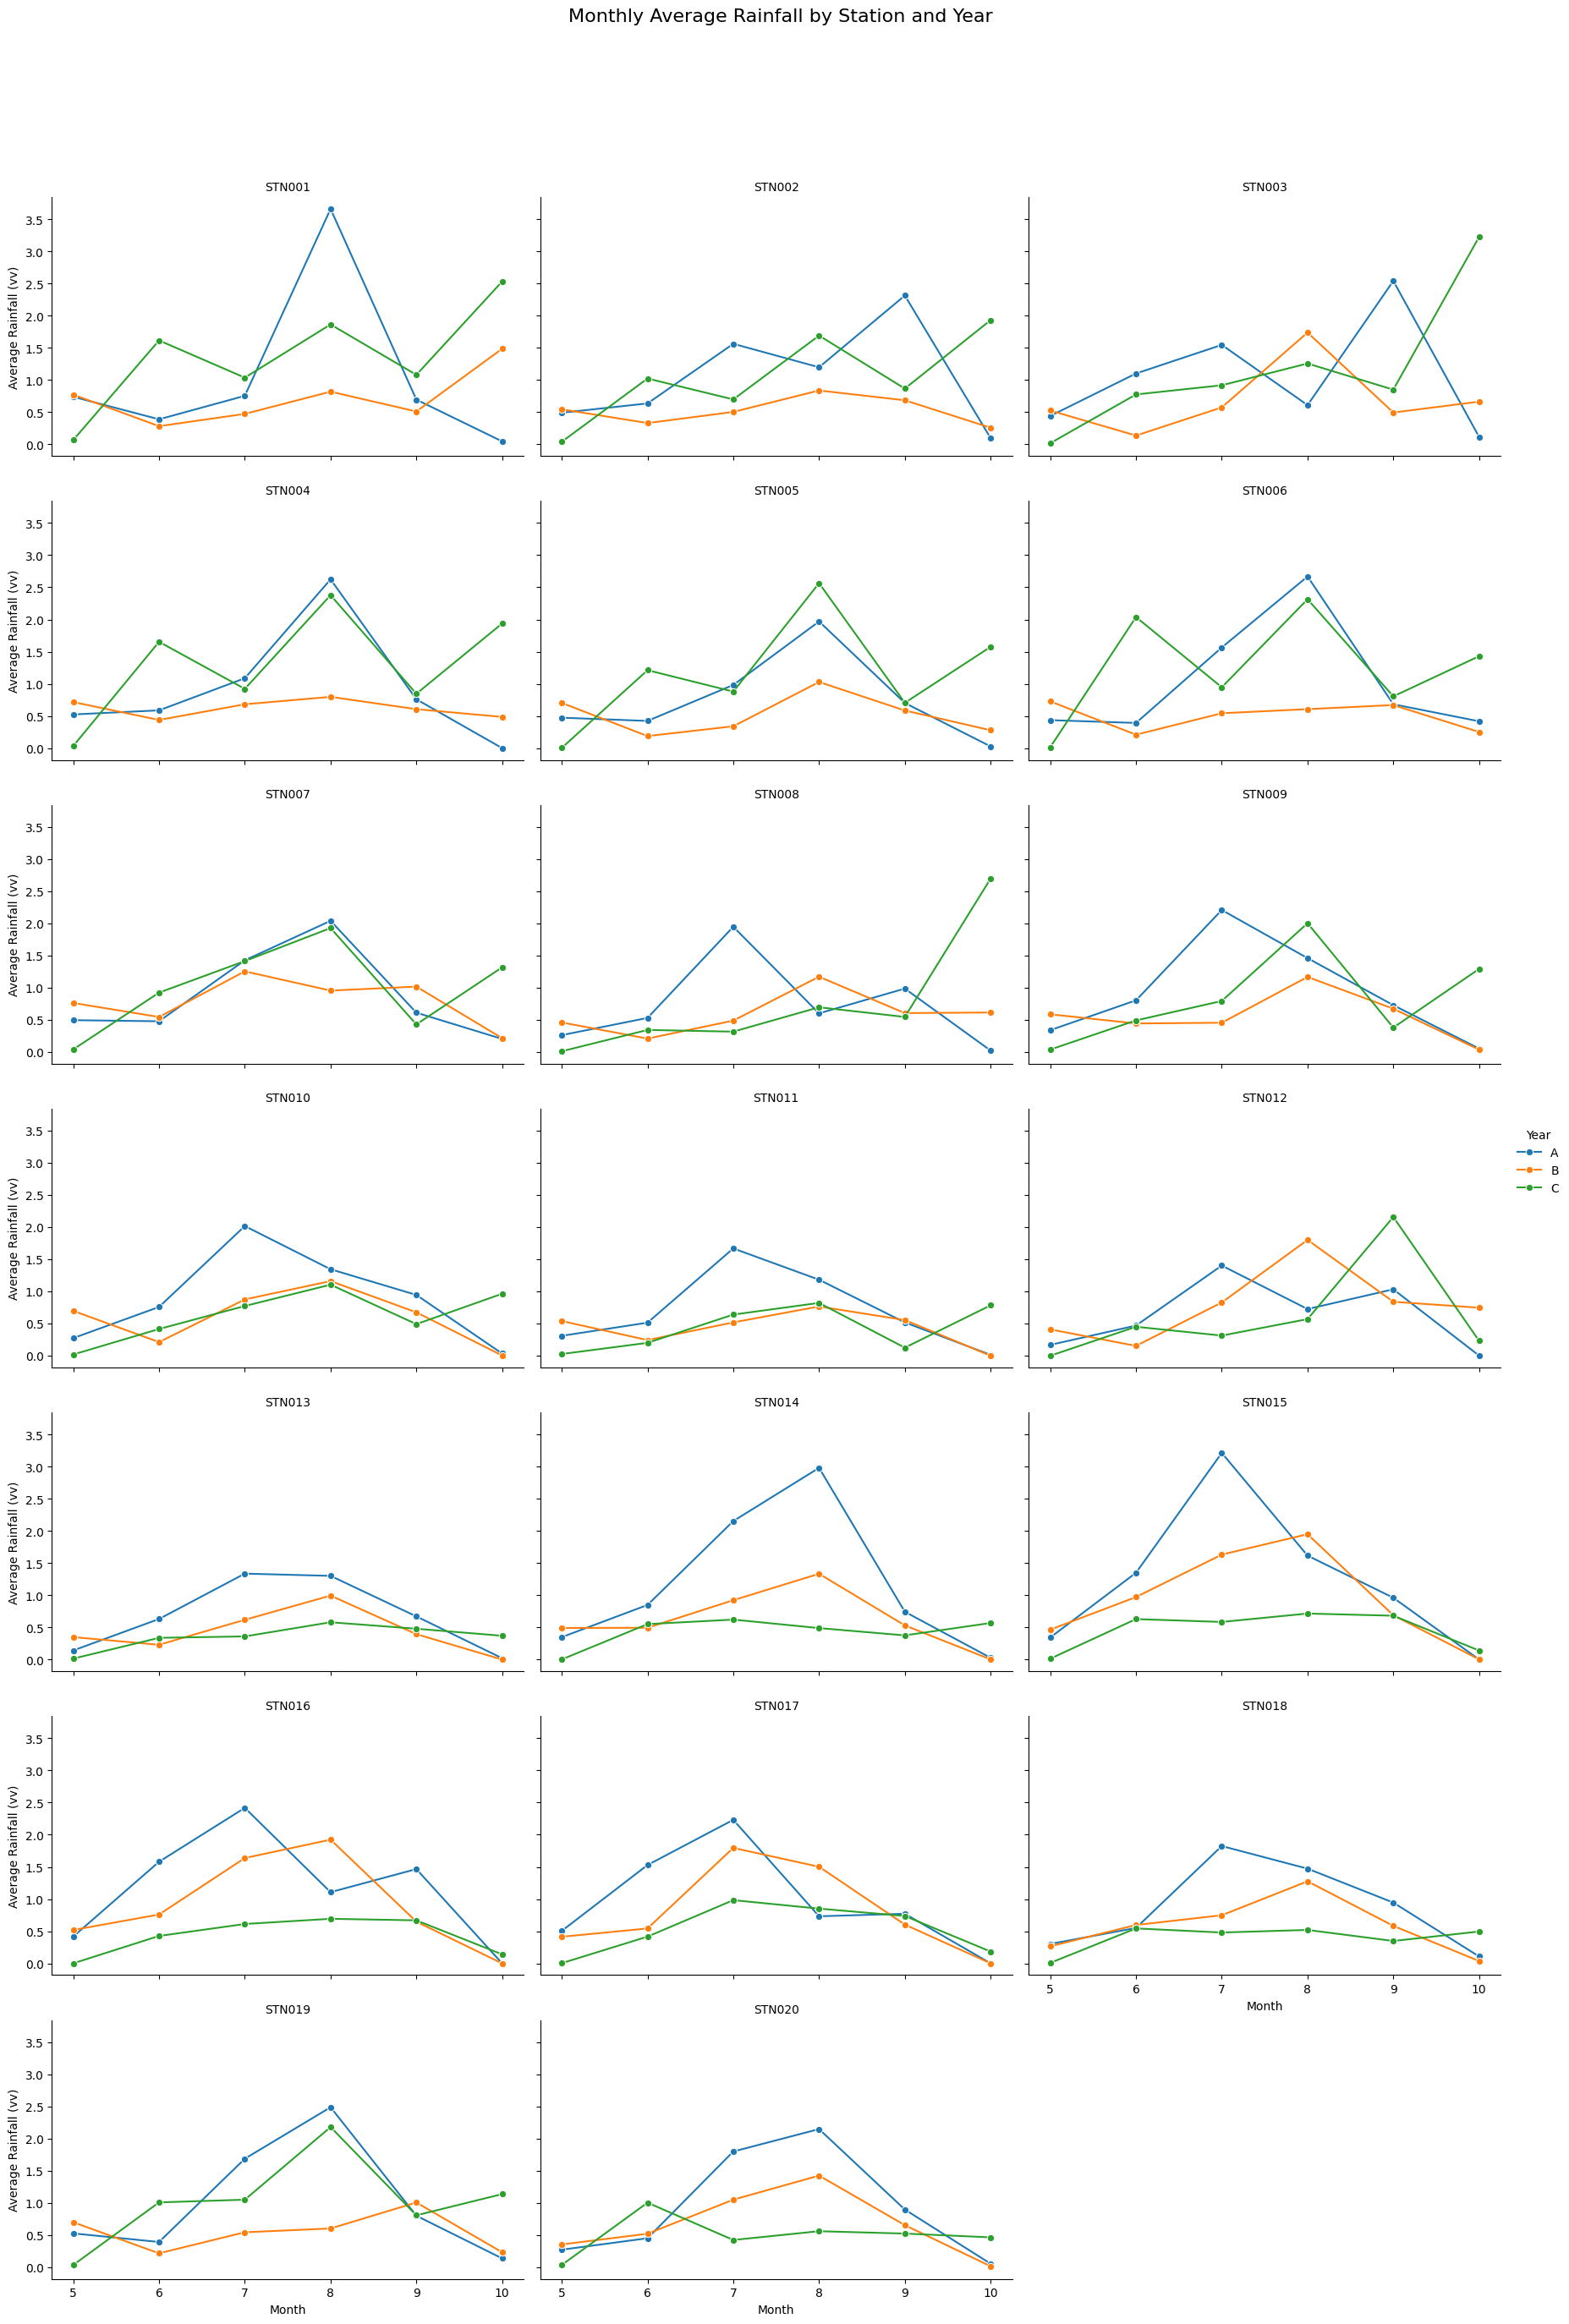

In [72]:
# 올바른 칼럼 이름을 사용하여 그룹화 및 분석
correct_column_names = {
    'stn4contest': 'rainfall_train.stn4contest',
    'ef_year': 'rainfall_train.ef_year',
    'ef_month': 'rainfall_train.ef_month',
    'vv': 'rainfall_train.vv'
}

# STN001부터 STN020까지의 지역, 년, 월별 그룹화
grouped_by_station_year_month = seperate_df.groupby([correct_column_names['stn4contest'], correct_column_names['ef_year'], correct_column_names['ef_month']])

# 각 그룹의 월별 평균 강수량 계산
monthly_mean_rainfall = grouped_by_station_year_month[correct_column_names['vv']].mean().reset_index()

# 시각화
g = sns.FacetGrid(monthly_mean_rainfall, col=correct_column_names['stn4contest'], col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, correct_column_names['ef_month'], correct_column_names['vv'], hue=correct_column_names['ef_year'], marker='o')

g.set_titles("{col_name}")
g.set_axis_labels("Month", "Average Rainfall (vv)")
g.add_legend(title='Year')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Monthly Average Rainfall by Station and Year', fontsize=16)
plt.show()

## 예측시점-예측시간 별로 CSI 비교

H (Hit): 정확한 예측.<br>
F (False Alarm): 강수량이 없는데 강수량이 있다고 예측한 경우.<br>
M (Miss): 강수량이 있는데 강수량이 없다고 예측한 경우.<br>
C (Correct Negative): 강수량이 없다고 예측했고 실제로도 강수량이 없는 경우.<br>

### 날짜 별로 최대 20개의 예측값이 존재하는 것을 확인

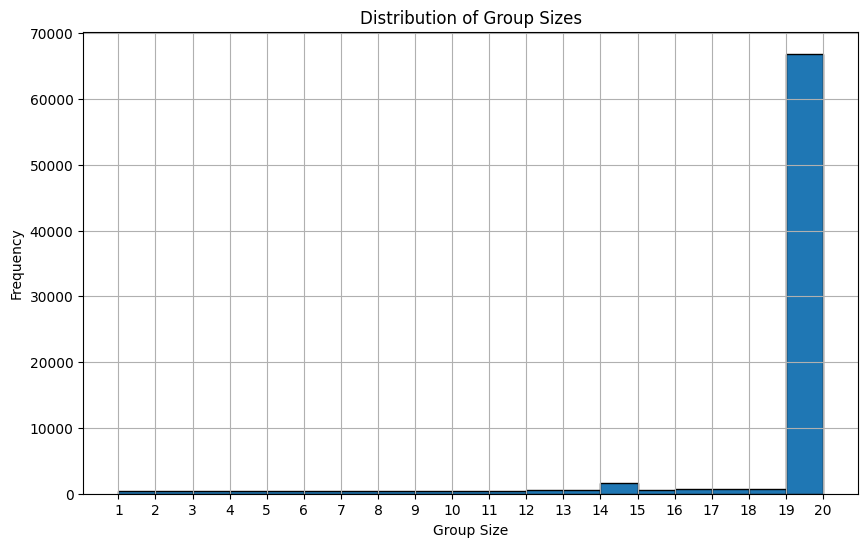

In [73]:
# 각 열이 동일한 행 그룹화
grouped = seperate_df.groupby(['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# 각 그룹의 크기 확인
group_sizes = grouped.size()

# 그룹 크기 분포 시각화
plt.figure(figsize=(10, 6))
group_sizes.hist(bins=range(1, group_sizes.max() + 1), edgecolor='black')
plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.xticks(range(1, group_sizes.max() + 1))
plt.show()


## 현재의 csi점수

ps. 날짜별로 하나의 예측값과 하나의 실제값을 비교해야 하지만,<br>
지금은 최종 예측을 어떻게 할 지 결정 못했으므로, 날짜 하나당 20개의 예측값과 20개의 실제값 비교

CSI: 0.05391754228709898
H: 15820, F: 125503, M: 152088, C: 1155351


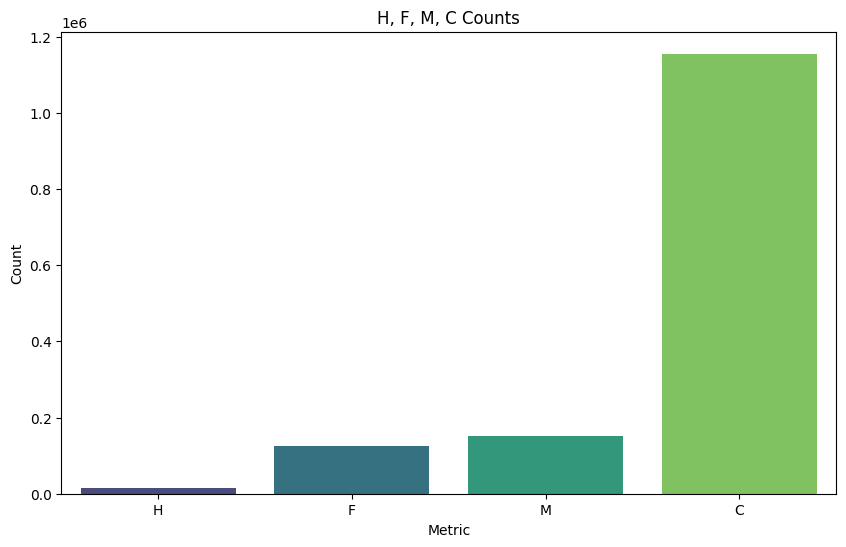

In [74]:
filtered_df=seperate_df

# 필요한 경우 인덱스 재설정
filtered_df.reset_index(drop=True, inplace=True)

# H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['estimated_rank'] != df['rainfall_train.class_interval'])).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(filtered_df)

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")

# H, F, M, C 값 시각화
metrics = pd.DataFrame({'Metric': ['H', 'F', 'M', 'C'], 'Count': [H, F, M, C]})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Count', data=metrics, palette='viridis')
plt.title('H, F, M, C Counts')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.show()

## dh(예측시간-예측시점)별 csi 계산 및 분포

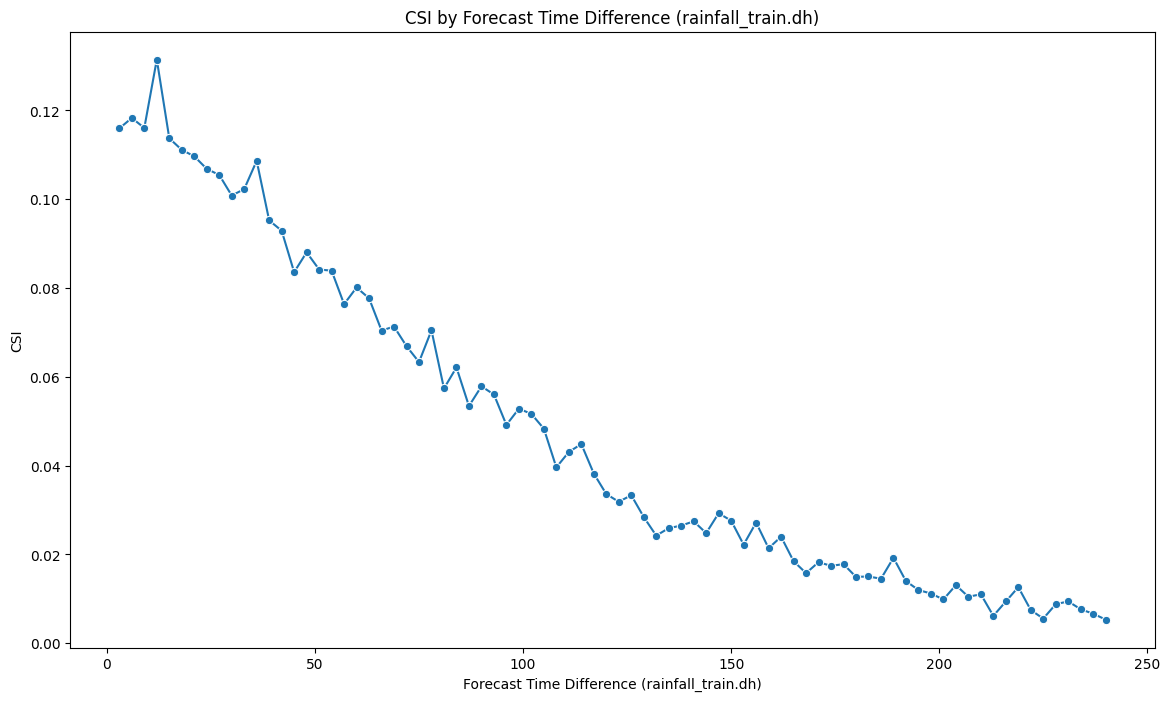

In [75]:
grouped = seperate_df.groupby([ 'rainfall_train.stn4contest','rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# 그룹 크기가 20인 데이터만 필터링
filtered_df = grouped.filter(lambda x: len(x) == 20)

# 'rainfall_train.dh' 별로 H, F, M, C 계산
dh_groups = filtered_df.groupby('rainfall_train.dh').apply(lambda x: pd.Series(calculate_csi_components(x), index=['H', 'F', 'M', 'C']))

# 'rainfall_train.dh' 별 CSI 계산
dh_groups['CSI'] = dh_groups.apply(lambda row: calculate_csi(row['H'], row['F'], row['M']), axis=1)

# CSI 값 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(x=dh_groups.index, y='CSI', data=dh_groups, marker='o')
plt.title('CSI by Forecast Time Difference (rainfall_train.dh)')
plt.xlabel('Forecast Time Difference (rainfall_train.dh)')
plt.ylabel('CSI')
plt.show()

### DH가 적을수록 CSI값이 높음을 확인 => DH가 낮으면 가중치를 높게 부여할까?

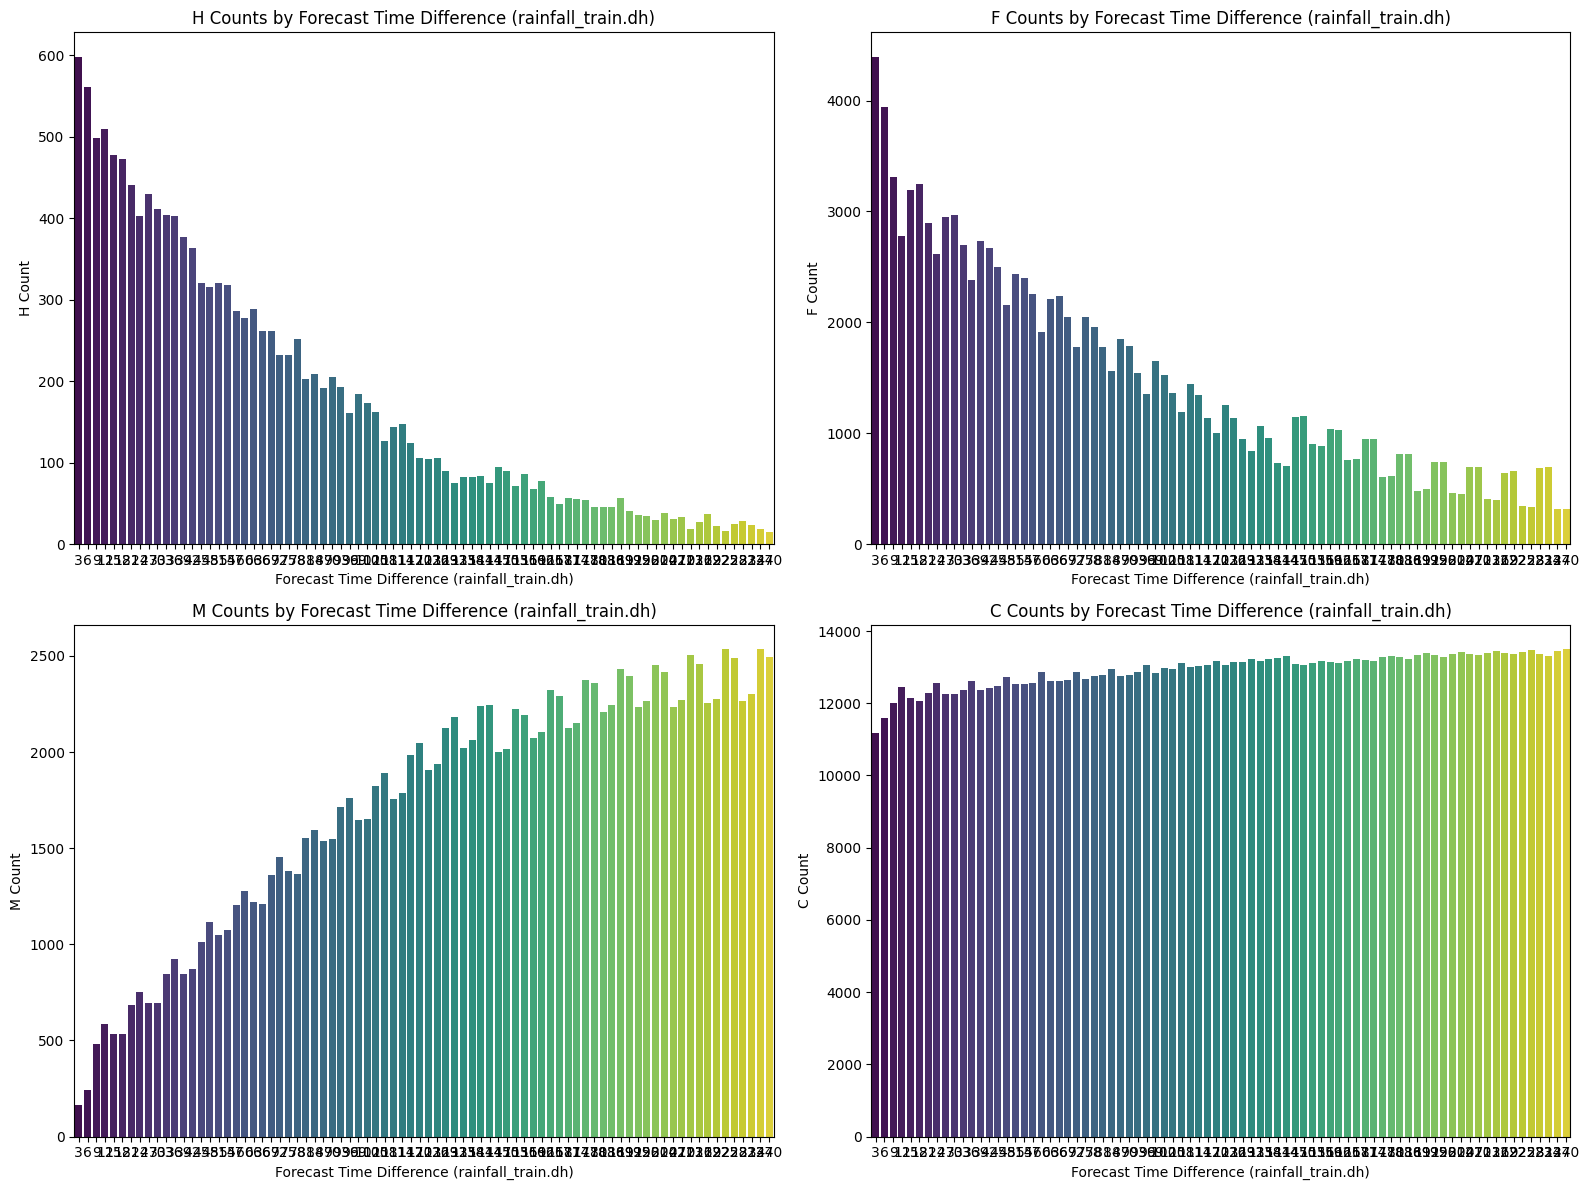

In [76]:
# 2x2 레이아웃으로 H, F, M, C 값 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['H', 'F', 'M', 'C']
for ax, metric in zip(axes.flatten(), metrics):
    sns.barplot(x=dh_groups.index, y=metric, data=dh_groups, palette='viridis', ax=ax)
    ax.set_title(f'{metric} Counts by Forecast Time Difference (rainfall_train.dh)')
    ax.set_xlabel('Forecast Time Difference (rainfall_train.dh)')
    ax.set_ylabel(f'{metric} Count')

plt.tight_layout()
plt.show()




### dh가 낮을 수록 H가 높아지고, M이 낮아 지는 긍정적인 효과는 있었지만, F도 높아진다.. 

1. 무작정 dh에 높은 가중치를 주면 안 됨.
2. F (False Alarm): 강수량이 없는데 강수량이 있다고 예측한 경우.
3. dh가 낮을수록 보수적 예측을 하나..?

# CSI를 높이기 위한 각종 시도들..

## 비교대상 기준: 단순평균가중 예측 - 날짜별로 모든 예측 값 평균내어 최종 예측값 계산. csi 평가

1. 각 그룹의 prob_{i} 값의 평균을 계산하여 대표값으로 설정.
2. 가장 높은 대표 prob_{i} 값을 찾아 예측값(estimated_rank)으로 설정.
3. 이 예측값과 실제 rainfall_train.class_interval 값을 비교하여 CSI를 계산.

In [77]:
# 각 열이 동일한 행을 그룹화 한 후
grouped = seperate_df.groupby(['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# 각 그룹의 prob_{i} 값의 평균을 계산
prob_columns = [f'prob_{i}' for i in range(10)]
grouped_means = grouped[prob_columns].mean()

# 대표 prob_{i} 값 중 가장 높은 값의 열의 i를 예측값(estimated_rank)으로 설정
grouped_means['estimated_rank'] = grouped_means.idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))

# 대표값과 실제값을 비교하여 H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# grouped_means에 실제값을 추가
grouped_means = grouped_means.reset_index()
actual_intervals = grouped[['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour', 'rainfall_train.class_interval']].first().reset_index(drop=True)
grouped_means = pd.merge(grouped_means, actual_intervals, on=['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(grouped_means)

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")


CSI: 0.04656696125084976
H: 548, F: 1380, M: 9840, C: 64157


## 시도1-가중평균(dh값 역수를 가중치로 설정해서 최종 예측값 산출)

In [78]:
# 가중치 계산 (가중치는 예측 시점과 예측 대상 시간의 차이의 역수로 설정)
seperate_df['weight'] = 1 / seperate_df['rainfall_train.dh']

# 각 열이 동일한 행을 그룹화 한 후
grouped = seperate_df.groupby(['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# 각 그룹의 prob_{i} 값의 가중 평균을 계산
prob_columns = [f'prob_{i}' for i in range(10)]
weighted_sum = grouped.apply(lambda x: (x[prob_columns].multiply(x['weight'], axis=0)).sum())
weight_sum = grouped['weight'].sum()
weighted_means = weighted_sum.div(weight_sum, axis=0)

# 대표 prob_{i} 값 중 가장 높은 값의 열의 i를 예측값(estimated_rank)으로 설정
weighted_means['estimated_rank'] = weighted_means.idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))

# 대표값과 실제값을 비교하여 H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# weighted_means에 실제값을 추가
weighted_means = weighted_means.reset_index()
actual_intervals = grouped[['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour', 'rainfall_train.class_interval']].first().reset_index(drop=True)
weighted_means = pd.merge(weighted_means, actual_intervals, on=['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(weighted_means)

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")

CSI: 0.18203748376322137
H: 1962, F: 4222, M: 4594, C: 61315


- 가중 평균하니까 CSI값 매우 올라감

## 시도2 -XGboost

In [79]:
# 예측에 사용할 특성 선택
features = [col for col in seperate_df.columns if 'prob_' in col] + ['rainfall_train.dh']
X = seperate_df[features]
y = seperate_df['rainfall_train.class_interval']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBClassifier(objective='multi:softprob', num_class=10, eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train, y_train)

# 예측
predicted_df = seperate_df.copy()
predicted_df['predicted_class'] = model.predict(X)

# 각 날짜(그룹)에 대한 대표 예측값을 단순 평균 방식으로 산출
grouped = predicted_df.groupby(['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# 평균 방식으로 대표 예측값 계산
def mean_vote(group):
    return group['predicted_class'].mean()

grouped_means = grouped.apply(mean_vote).reset_index(name='estimated_rank')

# 소수점 한 자리에서 반올림
grouped_means['estimated_rank'] = grouped_means['estimated_rank'].round(1).astype(int)

# 실제값 추가
actual_intervals = grouped[['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour', 'rainfall_train.class_interval']].first().reset_index(drop=True)
grouped_means = pd.merge(grouped_means, actual_intervals, on=['rainfall_train.stn4contest', 'rainfall_train.ef_year', 'rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour'])

# H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['estimated_rank'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['estimated_rank'] != 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    M = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['estimated_rank'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(grouped_means)

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")


CSI: 0.008692886674440794
H: 82, F: 157, M: 9194, C: 65380


대표값으로 했더니 csi 똥망..

## 시도3 - XgBoost 날짜별 대표값 산출이 아닌, 전체 행에 대한 csi 검사

In [80]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시 설정
warnings.filterwarnings("ignore")


# 예측에 사용할 특성 선택
features = [col for col in seperate_df.columns if 'prob_' in col] + ['rainfall_train.dh']
X = seperate_df[features]
y = seperate_df['rainfall_train.class_interval']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBClassifier(objective='multi:softprob', num_class=10, eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train, y_train)

# 예측
predicted_df = seperate_df.copy()
predicted_df['predicted_class'] = model.predict(X)

# 예측값을 소수점 한 자리에서 반올림
predicted_df['predicted_class'] = predicted_df['predicted_class'].round(1).astype(int)

# H, F, M, C 계산 함수
def calculate_csi_components(df):
    H = ((df['predicted_class'] != 0) & (df['rainfall_train.class_interval'] != 0) & (df['predicted_class'] == df['rainfall_train.class_interval'])).sum()
    F = ((df['predicted_class'] != 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    M = ((df['predicted_class'] == 0) & (df['rainfall_train.class_interval'] != 0)).sum()
    C = ((df['predicted_class'] == 0) & (df['rainfall_train.class_interval'] == 0)).sum()
    return H, F, M, C

# H, F, M, C 계산
H, F, M, C = calculate_csi_components(predicted_df)

# CSI 계산 함수
def calculate_csi(H, F, M):
    return H / (H + F + M) if (H + F + M) > 0 else 0

# CSI 계산
csi_value = calculate_csi(H, F, M)
print(f"CSI: {csi_value}")
print(f"H: {H}, F: {F}, M: {M}, C: {C}")


CSI: 0.03699670506858598
H: 7916, F: 1959, M: 204090, C: 1221356


In [81]:
seperate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448762 entries, 0 to 1448761
Data columns (total 34 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Unnamed: 0                     1448762 non-null  int64  
 1   rainfall_train.fc_year         1448762 non-null  object 
 2   rainfall_train.fc_month        1448762 non-null  int64  
 3   rainfall_train.fc_day          1448762 non-null  int64  
 4   rainfall_train.fc_hour         1448762 non-null  int64  
 5   rainfall_train.stn4contest     1448762 non-null  object 
 6   rainfall_train.dh              1448762 non-null  int64  
 7   rainfall_train.ef_year         1448762 non-null  object 
 8   rainfall_train.ef_month        1448762 non-null  int64  
 9   rainfall_train.ef_day          1448762 non-null  int64  
 10  rainfall_train.ef_hour         1448762 non-null  int64  
 11  rainfall_train.v01             1448762 non-null  int64  
 12  rainfall_train